# Data Mining Project 3
## By Julius Frank
### Review Bombing’s Effect on Biweekly Concurrent Players in Steam Games

## Introduction
[Review Bombing](https://en.wikipedia.org/wiki/Review_bomb) is a phenomenon where a large influx of negative reviews are given to a product after negative public relations events. Review bombing occurs most often in the video game industry and are characterized by reviews which do not focus on the game proper, but secondary aspects such as price, DRM (copyright-protection), a developer's other games, or public relations statements. A demonstrative example being [a mass influx of negative reviews to *Doom Eternal* after the creators of the game updated the game to include new DRM software.](https://www.destructoid.com/doom-eternal-adds-denuvo-on-pc-immediately-gets-review-bombed-591137.phtml) Previous case studies of specific review bombing events have shown [little impact on sales](https://www.pcgamer.com/steam-review-bombing-is-working-and-chinese-players-are-a-powerful-new-voice/), however, since many games reply on micro-transactions and in-game stores to generate revenue, it may be more important to ask if review bombing events affect the number of players actively playing a game. Perhaps review bombing voicing concern than dissatisfaction. This is what the present study investigates. 

Using data from Steam itself and SteamDB, I gather time series data on 200 popular steam games. Using ARIMA models to predict future sales before review bombing events, I investigate if there is evidence of a decrease in average weekly concurrent players after review bombing events in the short, medium, and long term. I find that there is strong evidence of a short-term effect, but weaker evidence for a medium and long term effect.
## Sampling Reasoning
The main reason I only consider very popular Steam games is because most Steam games are not continuously played, many fail to maintain a strong concurrent player count three months after launch. Because of this, many games can be said to have a "review bombing event" due to a small influx of negative reviews in a week because there are so few reviews being made. Having a large player-base prevents such things.
## Data Collection Process
Reviews were gathered using woctezuma's `steamreviews` package to mass download `.json` files containing review data. Data for concurrent player counts was obtained from [SteamDB](https://steamdb.info), for which I had to obtain special permission from the site owner to scrape their website. As such, SteamDB have asked me not to share instructions on how to scrape data from their website. Since the `steamreviews` package is rather self-explanatory from it's documentation, I opt not to include my raw data gathering code, the `.json` files for player data and review data are included in the `steamcharts` and `reviews` folders respectively. Data collection took some 3 day.
#### Errors in Data Collection
The `steamreviews` package doesn't always work perfectly, it can fail to retrieve an acceptable number of reviews (Usually only some 10% of all reviews). I am not entirely sure how to fix this, but in the end some games had to be discarded due to me facing repeated issues related to this. After filtering games that exhibit this error and games that have not been review bombed, about 70 games remained in my data set.

I created a `Game` object class to streamline data processing, the code for the class is below:

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np
import seaborn as sns
size=(30,10)
sns.set_theme()

# I realized too late that it's Concurrent, not Co-current, oops
def make_steamchart_df(appid):
    # yeah this variable probably shouldn't be called df, but whatever
    df = json.load(open('steamcharts/{0}_players.json'.format(appid),'r'))
    start = dt.datetime.fromtimestamp(df['data']['start'])
    d = {start: int(df['data']['values'][0])}
    step = dt.timedelta(seconds=df['data']['step'])
    for i in range(1,len(df['data']['values'])):
        # go one step
        start += step
        if df['data']['values'][i] is not None:
            d[start] = int(df['data']['values'][i])
        else:
            d[start] = np.nan
    return pd.DataFrame(d,index=['Co-current Players']).T

def make_review_df(appid,use_ijson=False):
    def make_review_dict(appid):
        def timestamp_to_dt(ts):
            return dt.datetime.fromtimestamp(ts)
        j = json.load(open('reviews/review_{0}.json'.format(appid),'r'))
        d = {}
        # timestamp in tuple's first slot, recommened in second
        review_ids = list(j['reviews'].keys())
        review_ids.reverse() # earilest reviews should appear first
        for review_id in review_ids:
            d[review_id] = (timestamp_to_dt(j['reviews'][review_id]['timestamp_created']),
                           int(j['reviews'][review_id]['voted_up']))
        return d
    df = pd.DataFrame(make_review_dict(appid),index=['Review Timestamp','Recommended?']).T
    # booleans will appear as objects, convert to int
    df['Recommended?'] = df['Recommended?'].astype(str).astype(int)
    num_reviewed = []
    for i in range(len(df)):
        num_reviewed.append(1)
    df['# of Reviews'] = num_reviewed
    df = df.set_index('Review Timestamp')
    return df

def make_full_df(appid,resample_format='W-MON'):
    aggfuns = {'Recommended?': np.sum,'# of Reviews': np.sum,
               'Co-current Players': np.mean}
    df = pd.concat([make_review_df(appid),make_steamchart_df(appid)],
                   axis=0,join='outer').resample(resample_format).agg(aggfuns)
    # only get rows after reviews are recorded
    for i in range(len(df)):
        if df.iloc[i,0] > 0:
            first_nz = i
            break
    df = df.iloc[first_nz:,:]
    df['Percent Recommended'] = df['Recommended?']/df['# of Reviews']
    return df

C:\Users\PC\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\PC\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\PC\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
class Game():
    games = []
    def __init__(self, appid):
        self.appid = appid #int
        self.name = id_to_game_dict[appid] #str
        self.data = make_full_df(appid) #DataFrame
        self.__class__.games.append(self)
    def has_review_bomb(self,stds_away=2):
        series = self.data['Percent Recommended']
        threshold = series.mean()-series.std()*stds_away
        for value in series:
            if value < threshold:
                return True
        return False
    def get_review_bomb_index(self,stds_away=2):
        if not self.has_review_bomb(stds_away=stds_away):
            return None
        else:
            series = self.data['Percent Recommended']
            threshold = series.mean()-series.std()*stds_away
            for value, n in zip(series,range(len(series))):
                if value < threshold:
                    yield n
    def plot_autocorr(self,col):
        pd.plotting.autocorrelation_plot(self.data[col])
        plt.show()


I have already created `Game` objects for the top 200 Steam games, they can be loaded from the `obj` folder

In [3]:
import pickle
import os

game_objects = []
spellcheck = {'Co-current Players': 'Concurrent Players'}

for appid in os.listdir('obj/'):
    exec('{0} = pickle.load(open(\'obj/{0}\',\'rb\'))'.format(appid))
    exec('{0}.data = {0}.data.rename(mapper=spellcheck,axis=1)'.format(appid))
    exec('game_objects.append({0})'.format(appid)) 

We can see a review bomb event for *Team Fortress 2* in mid-2016 via the `Game.plot()` corresponding to the release of the controversial "Meet Your Match Update" in which many community-requested features went ignored by the development team.

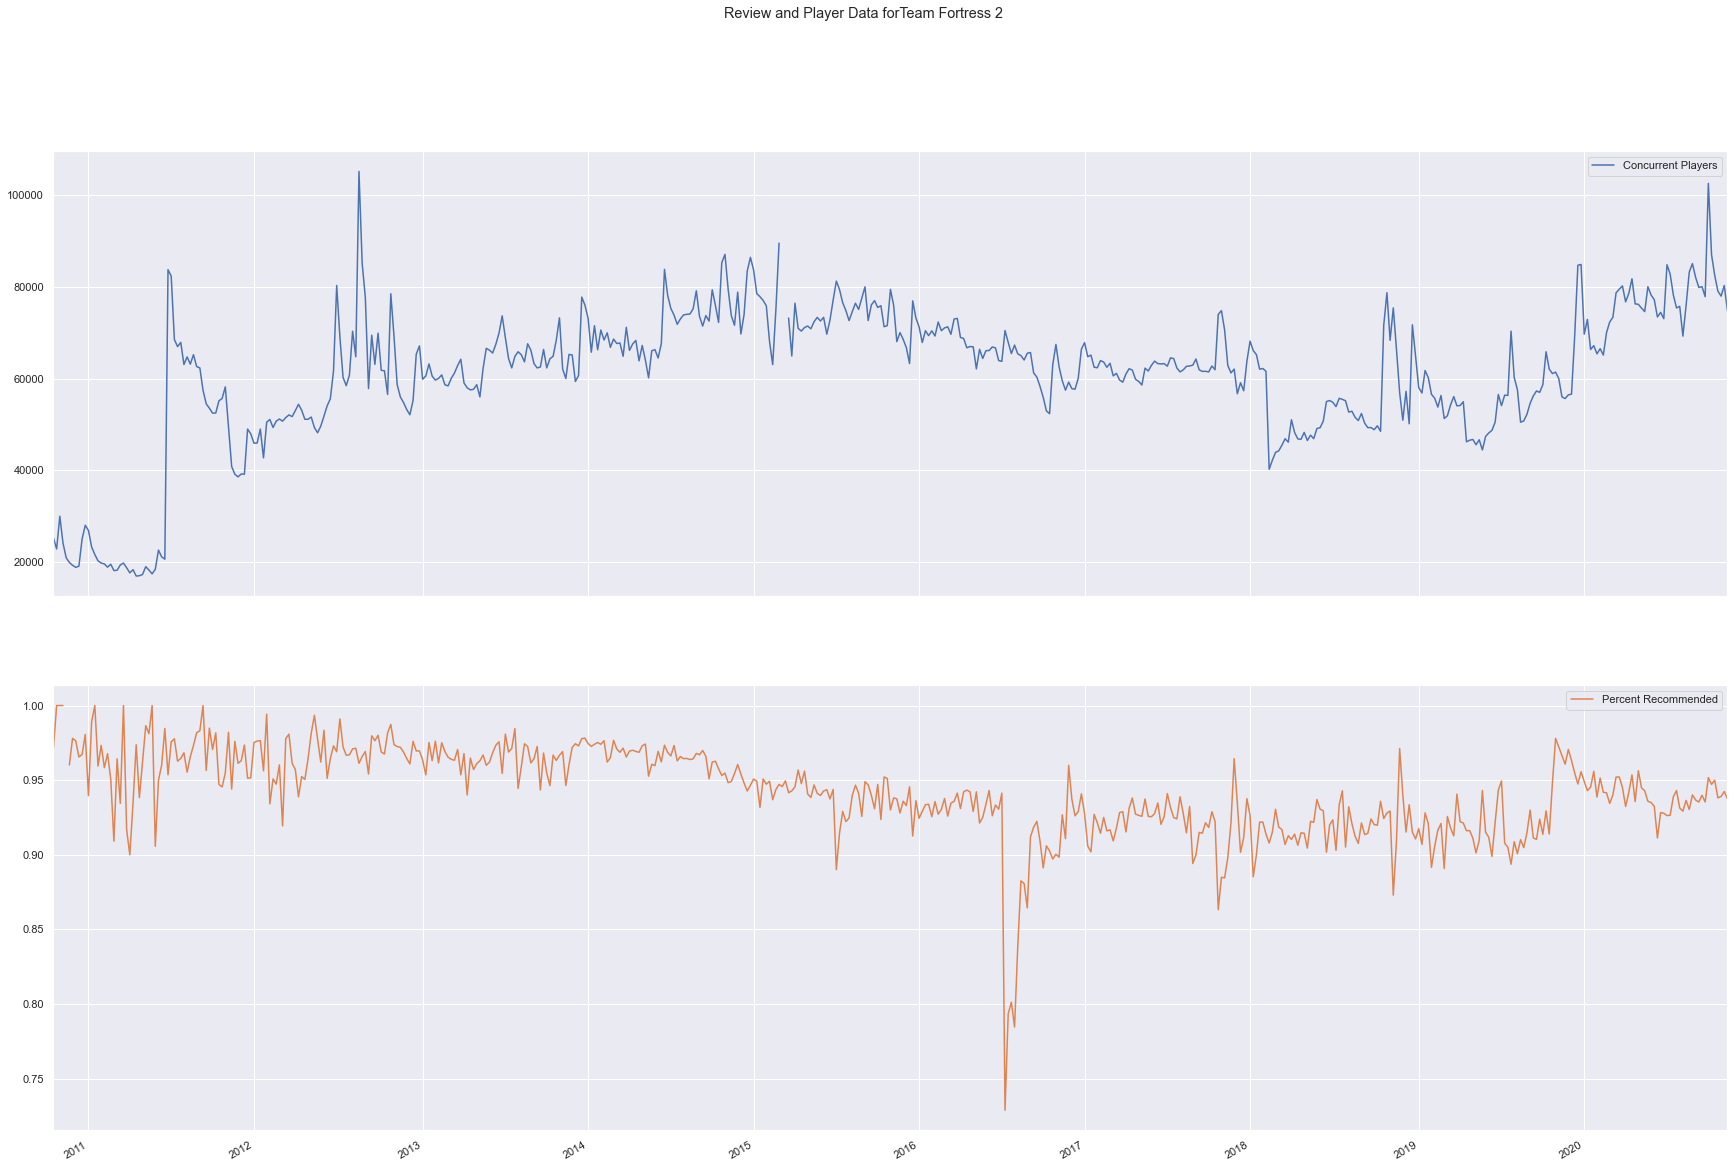

In [4]:
game440.data.loc[:,['Concurrent Players',
                    'Percent Recommended']].plot(figsize=(30,20),
                                                 subplots=True,
                                                 title='Review and Player Data for'+game440.name)
plt.show()

We can also see this in the cumlative precentage of the game

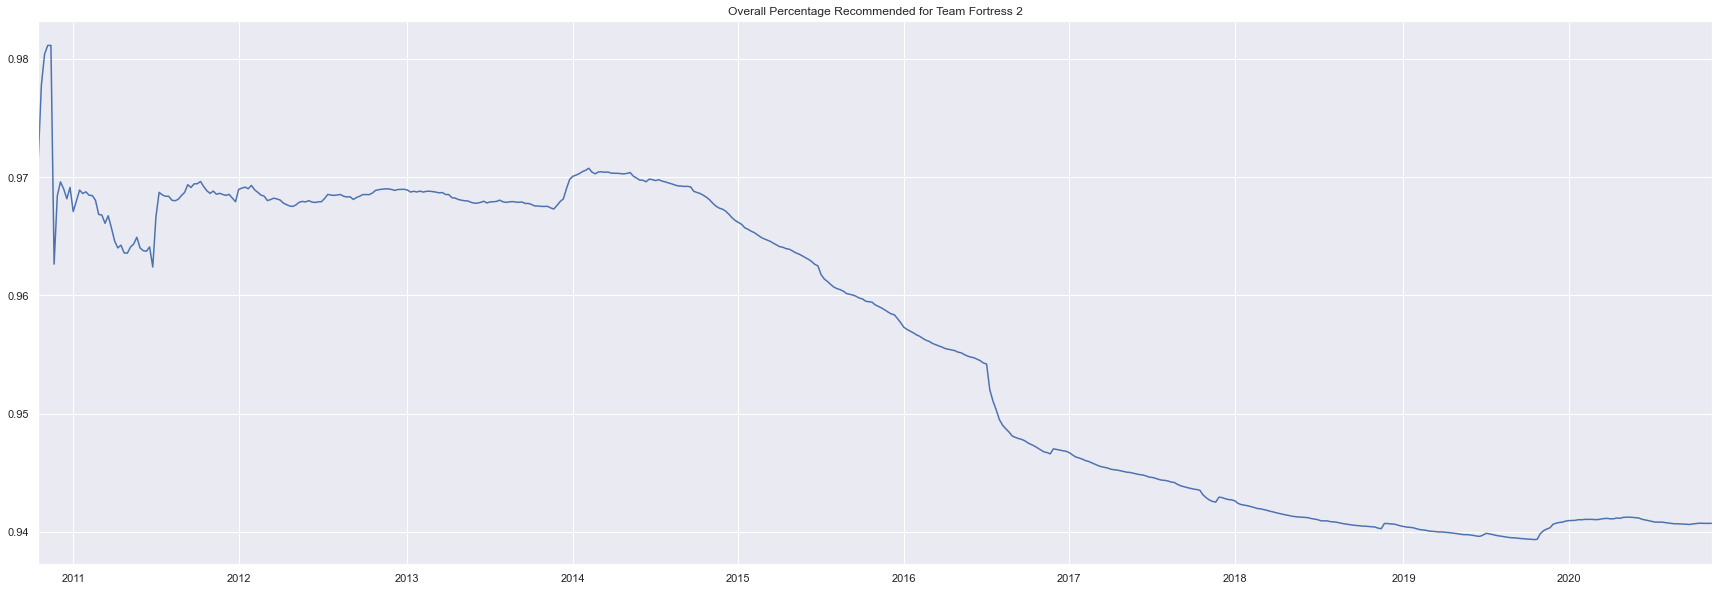

In [5]:
def show_cum_recommended(game,plot=True,retur=True):
    cum_recommended = game.data['Recommended?'].cumsum()/game.data['# of Reviews'].cumsum()
    if plot:
        cum_recommended.plot(title='Overall Percentage Recommended for '+game.name,figsize=size)
        plt.show()
    if retur:
        return cum_recommended

show_cum_recommended(game440,retur=False)

### Mining Games with Review Bomb Events
In order to filter games that do not have review bomb events, I look for games which have a point in their weekly review score which is 3 standard deviations lower than the mean weekly review score. The following code automatically filters games that don't have review bomb events.

In [6]:
def last_nan(series,look=4): #finds last time "look"-many nan values appear in a row in a series
    l = list(np.isnan(list(series))) #converts array to booleans showing if value is nan
    l.reverse()
    i = 0
    for n in range(len(l)):
        try:
            if all([l[n+m] for m in range(look)]): # if they are all nan
                i += 1
                return i
            i += 1
        except IndexError:
            i += 1
    return None


def diff_list(l): # differences between list indexes
    if len(l) < 2:
        return None
    diffs = []
    for i in range(len(l)-1):
        diffs.append(l[i+1]-l[i])
    return diffs

def get_review_bomb_index(series,stds_away=3):
    threshold = series.mean()-series.std()*stds_away
    for value, n in zip(series,range(len(series))):
        if value < threshold:
            yield n

def find_review_bomb_start(game,look=4):   
    series = game.data['Concurrent Players']
    valid_passed = last_nan(series,look=4)
    if valid_passed is not None:
        series = series[valid_passed:].fillna(series.mean())
    reviews = game.data['Percent Recommended'][valid_passed:]
    indexes = list(get_review_bomb_index(reviews))
    # ARIMA models require at least 50 observations to be valid
    if indexes is None or len(series) < 50 or len(indexes) == 0:
        return None
    starts = indexes
    for n in range(len(indexes)):
        try:
            # 50 obs
            if indexes[n] < 50:
                starts.remove(indexes[n])
            # is the next entry one more than the current entry?
            if indexes[n] + 1 == indexes[n+1]:
                starts.remove(indexes[n+1])
        except IndexError:
            pass
    # append final numeric index to list to help with spliting
    starts.append(len(game.data)-1)
    if len(starts) > 1:
        diff = diff_list(starts)
        # merge bomb events until there are at least 50 obs between the events
        while any([delta < 50 for delta in diff]):
            for i in range(len(diff)):
                # remove one at a time
                if diff[i] < 50:
                    starts.remove(starts[i+1])
                    break
            # recalculate differences
            diff = diff_list(starts)
            if diff is None:
                return starts
        return starts
    else:
        return None

bombed_games = [game for game in game_objects if find_review_bomb_start(game,look=2) is not None]

In [18]:
len(bombed_games)

81

## Statistical Testing

### ARIMA Models
**A**uto**r**egressive **I**ntegrated **M**oving **A**verage (ARIMA) models are a class of statistical models that can be used to forecast time series data. In layman's terms, ARIMA models state that time-labeled data can be represented by adding a certain percentage of the previous data points and a random value. Specifically, the second observation of time-labeled data can be expressed as the first observation plus some white noise. Every observation after that is then a combination of the last $p$ many values and the white noise component of the last $q$ many values. 

In technical terms ARIMA models model time series data as a sequence of random variables $\{X\}_{t=0}$. Let $BX_t=X_{t-1}, B^2X_t=X_{t-2}$ and so on. All ARIMA models can be expressed in the form
$$\left[1-\Phi(B)\right]X_t=\left[1+\Theta(B)\right]\epsilon_t,\quad \epsilon_i\sim\mathcal{N}\left(0,\sigma^2\right)$$
where
$$\Phi(B)=\sum_{i=1}^{p}\alpha_iB^i,\quad\Theta(B)=\sum_{i=1}^{q}\beta_iB^i$$
for some $p,q\in\mathbb{N}, \alpha_i,\beta_i\in[0,1)$. 
The "integrated" factor refers to differencing between time steps. This sometimes must be done to maintain model validity, as ARIMA models require a constant (technically, "stationary") mean. Luckily, such cases are still expressible in this general form, one need only shift $p$ by some factor of $d$. $d$ is explicitly given as the multiplicity of the [unit root](https://en.wikipedia.org/wiki/Unit_root) of the polynomial $\Phi$.

ARIMA models can be generated via the `AutoARIMA` function in the `pmdarima` package which will fit the best-possible ARIMA model to the data based on log-likelihood. The package can then make predictions based on the expected value of the ARIMA model, $\mathbb{E}\left[X_t\right]$, trained on data from the pre-review-bomb period to generate a time series estimation of later concurrent player counts where the review bomb did not occur. The mean percentage error between this predicted time series and the true time series will serve as the metric to judge the strength of review bombing events. Mean percentage error is used to account for differences in popularity among the games in the data set.

In [7]:
# declearing methods to generate ARIMA models
from pmdarima.arima import AutoARIMA
from math import sqrt, floor

def split_players_on_bomb(game):
    #split the players time series into series before and after the review bomb effect
    starts = find_review_bomb_start(game)
    ts = game.data['Concurrent Players']
    if len(starts) == 0 or starts is None:
        assert 'Cannot find valid review bomb event for {0} (appid: {1})'.format(game.name,game.appid)
    else:
        if len(starts) == 1:
            s = starts[0]
            yield ts[:s-1]
            yield ts[s+1:]
        else:
            for s in starts:
                i = starts.index(s)
                if i == 0:
                    yield ts[:s-1]
                    yield ts[s+1:starts[i+1]-1]
                elif i != len(starts) - 1:
                    yield ts[s+1:starts[i+1]-1]
                else:
                    if s != len(game.data) - 1:
                        yield ts[s+1:]


def est_bomb_effect(game,term=0):
    # term is the number of weeks the estimator should look ahead with
    l_of_ts = list(split_players_on_bomb(game))
    if len(l_of_ts) == 2:
        before = l_of_ts[0]
        after = l_of_ts[1]
        if term == 0:
            term = len(after)
        model = AutoARIMA()
        try:
            prediction = model.fit_predict(before.fillna(before.mean()),n_periods=term)
            error = (after[:term] - prediction)/after[:term] # signed percentage error
            yield error
        except ValueError: #sometimes returns empty series
            pass
    else:
        mean_errors = []
        for i in range(len(l_of_ts)-1):
            before = l_of_ts[i]
            after = l_of_ts[i+1]
            if term == 0:
                term = len(after)
            try:
                model = AutoARIMA()
                prediction = model.fit_predict(before.fillna(before.mean()),n_periods=term)            
                error = (after[:term] - prediction)/after[:term]
                yield error
            except ValueError:
                pass

def plot_review_bomb_eff(game,term=0):
    title = 'Percentage change in Concurrent players for '
    if term == 0:
        title += game.name
    else:
        title += game.name+' {0} weeks after review bomb event'.format(term)
    mes = list(est_bomb_effect(game,term=term))
    for me in list(mes):
        me.plot(figsize=size,title=title)
    plt.show()
    
def get_review_bomb_eff(game,term=0):
    mean_signed_errors = []
    mes = list(est_bomb_effect(game,term=term))
    for me in list(mes):
        if len(me) > 0: #fail-safe
            mean_signed_errors.append(me.mean())
    return np.mean(mean_signed_errors)

ARIMA estimation is quite computationally expensive, so I opt to use multi-trending

In [8]:
import warnings
import threading
from math import ceil

mean_signed_errors_main = {}

class RB_eff_getter(threading.Thread):
    def __init__(self,threadID,name,begin,stop,ls):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.begin = begin # what index to start at
        self.stop = stop # What index to stop at
        self.ls = ls # iterable to parse
    def run(self):
        for game in self.ls[self.begin:self.stop]:
            global mean_signed_errors_main
            mean_signed_errors_main[game.appid] = (get_review_bomb_eff(game,term=25),get_review_bomb_eff(game,term=15),get_review_bomb_eff(game,term=5))
            print('.',end='')

warnings.filterwarnings("ignore")

threadLock = threading.Lock()
threads = []

print('Getting Review Bomb Effects')
split_by_threads = 10
for i in range(0,ceil(len(bombed_games)/split_by_threads)):
    try:
        exec('REEG{1} = RB_eff_getter({1},\'Thread {1}\',{0}*{2},(({1})*{2})-1,bombed_games)'.format(i,i+1,split_by_threads))
        exec('REEG{0}.start()'.format(i+1))
        exec('threads.append(REEG{0})'.format(i+1))
    except IndexError:
        REEGfinal = RB_eff_getter(i+1,'Thread {0}'.format(i+1),i*split_by_threads,len(bombed_games)-1,bombed_games)
        REEGfinal.start()
        threads.append(REEGfinal)

for t in threads:
    t.join()
print()
print('Done!')

Getting Review Bomb Effects
.........................................................................
Done!


In [9]:
# making dict to translate appids
import csv

id_to_game_dict = {}
games = csv.reader(open('top1000steam.csv','r',encoding='utf-8'))
i = 0
for row in games:
    id_to_game_dict[int(row[2])] = row[0]
# for some reason reading wouldn't work with this game in the file so I added it manually
id_to_game_dict[35700] = 'Trine Enchanted Edition'
#inverse dictionary
game_to_id_dict = {}
for k, v in id_to_game_dict.items():
    game_to_id_dict[v] = k

In [10]:
# making error df
short_term = 'Short-term Review Bomb Effect (5 weeks)'
mid_term = 'Medium-term Review Bomb Effect (15 weeks)'
long_term = 'Long-term Review Bomb Effect (25 weeks)'
review_bomb_eff_df = pd.DataFrame(mean_signed_errors_main,index=[long_term,mid_term,short_term]).T*100
review_bomb_eff_df['Game Name'] = [id_to_game_dict[i] for i in review_bomb_eff_df.index]

We may now generate descriptive statistics for the review bomb effect of each term length

In [11]:
review_bomb_eff_df.dropna().describe()

,Long-term Review Bomb Effect (25 weeks),Medium-term Review Bomb Effect (15 weeks),Short-term Review Bomb Effect (5 weeks)
count,72.000000,72.000000,72.000000
mean,-83.005382,-69.180567,-66.781793
std,268.913492,257.057211,234.835334
min,-1552.735071,-1996.633948,-1797.020743
25%,-50.482062,-38.689960,-44.340836
50%,-8.992907,-6.763253,-0.515513
75%,16.295495,16.048220,13.507898
max,132.797478,82.478413,47.763262


It seems that there are games with very major losses from review bombing events, I check this via histogram.

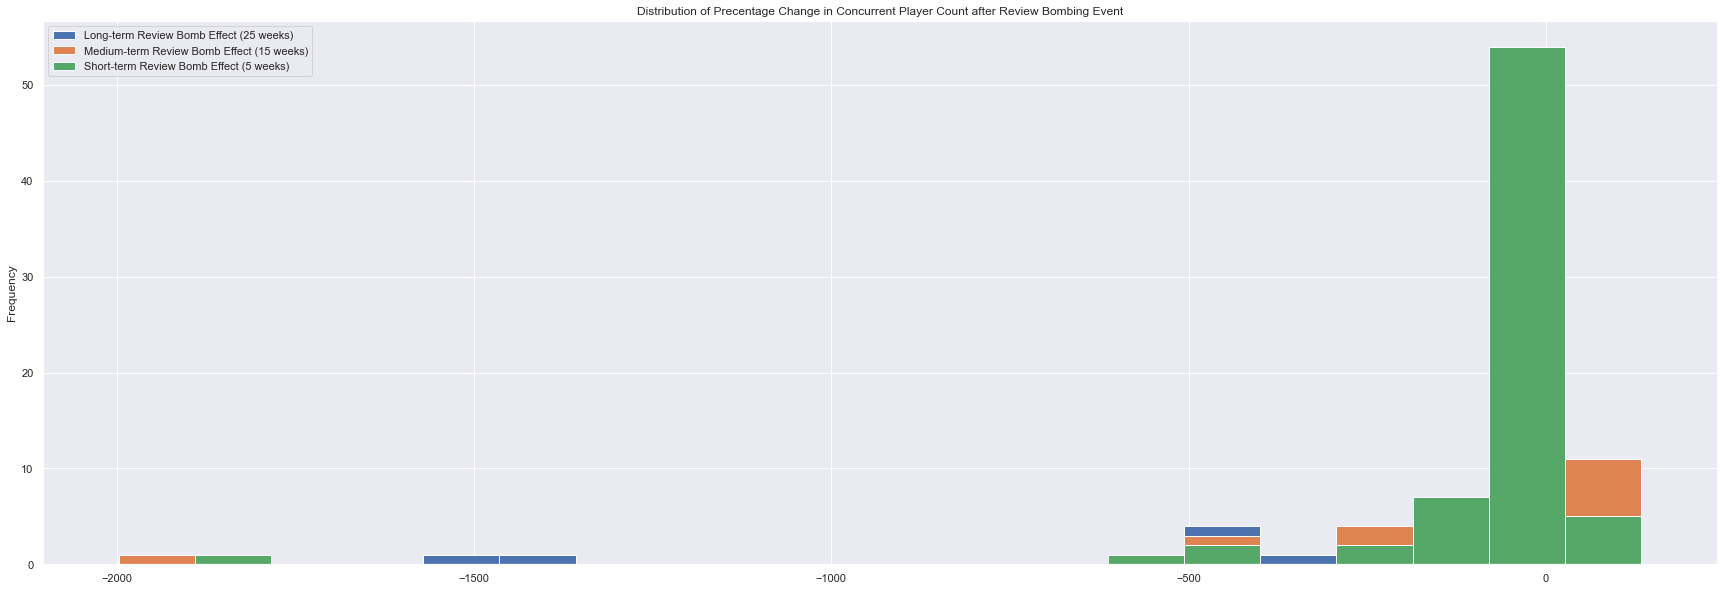

In [12]:
review_bomb_eff_df.dropna().plot.hist(figsize=size,bins=20,title='Distribution of Precentage Change in Concurrent Player Count after Review Bombing Event')
plt.show()

Given the existence of extreme values from the histogram, I opt to remove outliers from my data set.

In [13]:
from scipy.stats import zscore

def remove_outliers(df,rounds=2):
    i = 0
    clean = df.dropna()
    # clean the data in rounds, outliers may hide the existence of even more outliers
    while i < rounds:
        # calculate Z score for all data points
        Z = np.abs(zscore(clean.loc[:,[long_term,mid_term,short_term]]))
        # get indexes of outliers
        to_remove = np.where(Z > 3)
        to_remove_labels = [clean.index[i] for i in list(set(to_remove[0]))]
        clean = clean.drop(to_remove_labels)
        i += 1
    return clean

review_bomb_eff_df_clean = remove_outliers(review_bomb_eff_df)

In [14]:
review_bomb_eff_df_clean.describe()

,Long-term Review Bomb Effect (25 weeks),Medium-term Review Bomb Effect (15 weeks),Short-term Review Bomb Effect (5 weeks)
count,65.000000,65.000000,65.000000
mean,-16.899673,-16.096100,-15.423576
std,77.150167,65.616488,51.989141
min,-345.827089,-259.424691,-199.869738
25%,-34.079372,-24.870464,-25.808589
50%,-5.618843,-5.398261,0.949599
75%,16.873663,17.590508,14.506469
max,132.797478,82.478413,47.763262


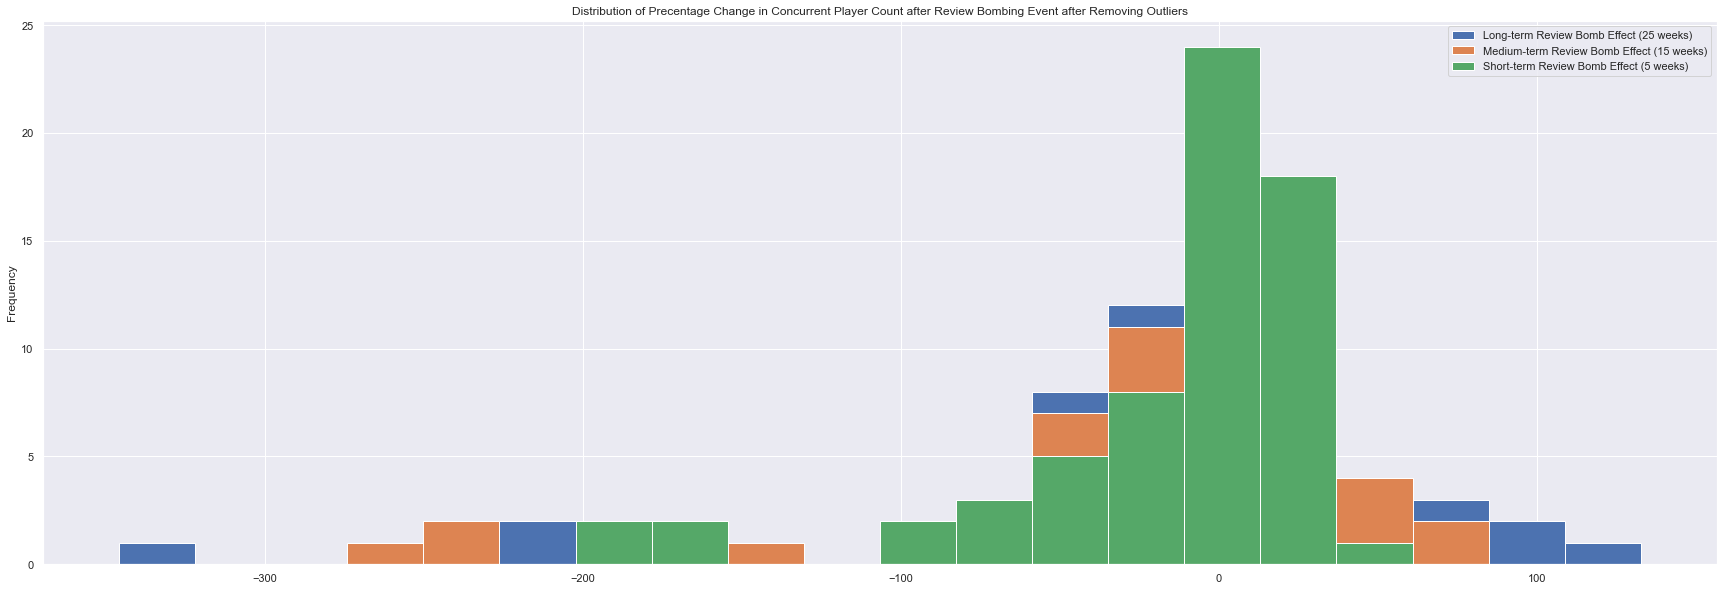

In [15]:
review_bomb_eff_df_clean.plot.hist(figsize=size,bins=20,title='Distribution of Precentage Change in Concurrent Player Count after Review Bombing Event after Removing Outliers')
plt.show()

As we can see, there is strong evidence from the histogram and descriptive statistics that review bombing does have a negative impact on player bases in the short term. The medium and long term effects are a bit more difficult to see, so I opt to use a $Z$-test on the mean of each the term periods

In [16]:
from statsmodels.stats.weightstats import ztest
for term in [short_term,mid_term,long_term]:
    resultZ = ztest(review_bomb_eff_df_clean[term].dropna(),
                    alternative='smaller')
    print('Result of Z test against H0: μ ≥ 0 for',term.split()[0]+':')
    print('Z =',round(resultZ[0],3),'(p = {0})'.format(round(resultZ[1],3)))

Result of Z test against H0: μ ≥ 0 for Short-term:
Z = -2.392 (p = 0.008)
Result of Z test against H0: μ ≥ 0 for Medium-term:
Z = -1.978 (p = 0.024)
Result of Z test against H0: μ ≥ 0 for Long-term:
Z = -1.766 (p = 0.039)


As we can see, the $p$-values are significantly negative at a significance level of $\alpha=0.05$, in fact, the short-term effect is found to be negative even at a significance level of $\alpha=0.01$. This essentially the chance that review bombing events on average have a negative impact on player base is more than 95% for each term length.

One may question how often player loss from review-bombing events is prolonged in the short term. To this extent, I display the correlation matrix of my data.

In [17]:
review_bomb_eff_df_clean.corr()

,Long-term Review Bomb Effect (25 weeks),Medium-term Review Bomb Effect (15 weeks),Short-term Review Bomb Effect (5 weeks)
Long-term Review Bomb Effect (25 weeks),1.000000,0.898958,0.649668
Medium-term Review Bomb Effect (15 weeks),0.898958,1.000000,0.779988
Short-term Review Bomb Effect (5 weeks),0.649668,0.779988,1.000000


As we can see, while short-term loss often translates to medium-term lost and medium-term lost is quite indicative of long-term loss, the relationship between short and long term player loss is less significant, meaning we shouldn't always except review bombing to cause long term damage to a game's player base.

# Conclusion
- There is significant evidence that review bombing has a short-term negative effect on a game's player base.
- There is much less significant evidence for a long or medium term negative effect.
- Most losses from review bombing are not catastrophic.
- Shot-term losses do translate into long-term losses a slight majority of the time, but not always.
## Research Suggestions
It may be interesting to see if the same relationship can be seen in *sales* rather than player count. Sadly, information about sales of Steam games is only kept by internal analytics departments or the payed website [SteamSpy](https://steamspy.com). If one were to take on this research, I would recommend trying to isolate the effects of price drops, which would require much more econometric analysis than I have done in this report.